## XGBoost - composite sensors - 2bins - 50/50

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [2]:
df = pd.read_csv(f"../DetectionResponseSensors_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_type         56 non-null     object 
 1   ZnO_content         56 non-null     int64  
 2   temperature         56 non-null     int64  
 3   sensing             56 non-null     float64
 4   sensing_2bins_7030  56 non-null     int64  
 5   sensing_2bins_5050  56 non-null     int64  
 6   sensor_conds        56 non-null     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ KB


In [3]:
df["sensor_type"].unique()

array(['core-shell', 'composite'], dtype=object)

In [4]:
target = "sensing_2bins_5050"
representation = ["sensor_type", "ZnO_content", "temperature"]
random_state=42
train_size=40

In [5]:
encoded_sensor_type = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoded_sensor_type.fit_transform(df[["sensor_type"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sensor_type             56 non-null     object 
 1   ZnO_content             56 non-null     int64  
 2   temperature             56 non-null     int64  
 3   sensing                 56 non-null     float64
 4   sensing_2bins_7030      56 non-null     int64  
 5   sensing_2bins_5050      56 non-null     int64  
 6   sensor_conds            56 non-null     object 
 7   sensor_type_composite   56 non-null     float64
 8   sensor_type_core-shell  56 non-null     float64
dtypes: float64(3), int64(4), object(2)
memory usage: 4.1+ KB


In [7]:
df.columns[7:9].to_list()

['sensor_type_composite', 'sensor_type_core-shell']

In [8]:
representation = ["ZnO_content", "temperature"]
representation.extend(df.columns[7:9].to_list())

In [9]:
representation

['ZnO_content',
 'temperature',
 'sensor_type_composite',
 'sensor_type_core-shell']

In [27]:
def prepare_dataset_classification(
    df,
    target = "sensing_2bins_5050",
    representation=representation,
    random_state=42,
    train_size=40
):
    df_train, df_val_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_val_test))
    
    df_val, df_test = train_test_split(
        df_val_test,
        train_size=0.5,
        random_state=random_state,
        stratify=df_val_test[target].astype(int).values,
    )
    print(len(df_val), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_val, y_val = df_val[representation], df_val[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=200, 
        random_state=random_state, 
        early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [29]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 15

In [30]:
train_size = 15
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [31]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 41
20 21
random_state = 42
[0]	validation_0-logloss:0.59026	validation_1-logloss:0.62095
[5]	validation_0-logloss:0.39215	validation_1-logloss:0.51273
[10]	validation_0-logloss:0.35105	validation_1-logloss:0.46237
[15]	validation_0-logloss:0.34373	validation_1-logloss:0.45094
[20]	validation_0-logloss:0.34229	validation_1-logloss:0.44776
[25]	validation_0-logloss:0.34200	validation_1-logloss:0.44647
[30]	validation_0-logloss:0.34194	validation_1-logloss:0.44578
[35]	validation_0-logloss:0.34193	validation_1-logloss:0.44553
[40]	validation_0-logloss:0.34193	validation_1-logloss:0.44538
[45]	validation_0-logloss:0.34193	validation_1-logloss:0.44533
[50]	validation_0-logloss:0.34193	validation_1-logloss:0.44531
[55]	validation_0-logloss:0.34193	validation_1-logloss:0.44531
[60]	validation_0-logloss:0.34193	validation_1-logloss:0.44531
[65]	validation_0-logloss:0.34193	validation_1-logloss:0.44531
[70]	validation_0-logloss:0.34193	validation_1-logloss:0.44531

[51]	validation_0-logloss:0.29009	validation_1-logloss:0.52169
Accuracy: 0.7142857142857143
F1 macro: 0.7136363636363636
F1 micro: 0.7142857142857143
F1 weighted: 0.7142857142857143
Kappa: 0.42727272727272725


In [32]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.7285714285714286 +/- 0.0640648764146367
mean F1 macro: 0.7245663764153467 +/- 0.06472536268143941
mean F1 micro: 0.7285714285714286 +/- 0.0640648764146367
mean F1 weighted: 0.7243165458403041 +/- 0.06506510243585478
mean Kappa: 0.45924733520201394 +/- 0.12695164954211113


In [33]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.761905,0.752941,0.761905,0.750700,0.533333
1,15,"[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, ...",0.666667,0.663616,0.666667,0.662090,0.340807
2,15,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.714286,0.713636,0.714286,0.714286,0.427273


### training size = 20

In [34]:
train_size = 20
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [35]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
20 36
18 18
random_state = 42
[0]	validation_0-logloss:0.58198	validation_1-logloss:0.63432
[5]	validation_0-logloss:0.35654	validation_1-logloss:0.53862
[10]	validation_0-logloss:0.30245	validation_1-logloss:0.52850
[15]	validation_0-logloss:0.27961	validation_1-logloss:0.52614
[17]	validation_0-logloss:0.27345	validation_1-logloss:0.52879
Accuracy: 0.8333333333333334
F1 macro: 0.8328173374613003
F1 micro: 0.8333333333333334
F1 weighted: 0.8328173374613003
Kappa: 0.6666666666666667
-------------Iteration 2/10
20 36
18 18
random_state = 43
[0]	validation_0-logloss:0.58198	validation_1-logloss:0.59852
[5]	validation_0-logloss:0.36856	validation_1-logloss:0.56583
[10]	validation_0-logloss:0.30965	validation_1-logloss:0.57727
[11]	validation_0-logloss:0.30196	validation_1-logloss:0.60457
Accuracy: 0.6666666666666666
F1 macro: 0.6666666666666666
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.33333333333333337
-------------Iteration 3/10
20

In [36]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 20
mean accuracy: 0.7555555555555555 +/- 0.05091750772173158
mean F1 macro: 0.7518141275649015 +/- 0.05051425831081946
mean F1 micro: 0.7555555555555555 +/- 0.05091750772173158
mean F1 weighted: 0.7518141275649015 +/- 0.05051425831081948
mean Kappa: 0.5111111111111112 +/- 0.10183501544346314


In [37]:
compiled_res_20 = pd.DataFrame(metrics_dict())
compiled_res_20.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,20,"[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ...","[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, ...",0.833333,0.832817,0.833333,0.832817,0.666667
1,20,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, ...",0.666667,0.666667,0.666667,0.666667,0.333333
2,20,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...","[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...",0.722222,0.714286,0.722222,0.714286,0.444444


### training size = 25

In [38]:
train_size = 25
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [39]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
25 31
15 16
random_state = 42
[0]	validation_0-logloss:0.56670	validation_1-logloss:0.57167
[5]	validation_0-logloss:0.34410	validation_1-logloss:0.37580
[10]	validation_0-logloss:0.28281	validation_1-logloss:0.31423
[15]	validation_0-logloss:0.26137	validation_1-logloss:0.28999
[20]	validation_0-logloss:0.24683	validation_1-logloss:0.26994
[25]	validation_0-logloss:0.23578	validation_1-logloss:0.25849
[30]	validation_0-logloss:0.22723	validation_1-logloss:0.25090
[35]	validation_0-logloss:0.22028	validation_1-logloss:0.24558
[40]	validation_0-logloss:0.21452	validation_1-logloss:0.24008
[45]	validation_0-logloss:0.20972	validation_1-logloss:0.23581
[50]	validation_0-logloss:0.20573	validation_1-logloss:0.23084
[55]	validation_0-logloss:0.20349	validation_1-logloss:0.22480
[60]	validation_0-logloss:0.20126	validation_1-logloss:0.22239
[65]	validation_0-logloss:0.19930	validation_1-logloss:0.21983
[70]	validation_0-logloss:0.19872	validation_1-logloss:0.21697

[100]	validation_0-logloss:0.29425	validation_1-logloss:0.25401
[105]	validation_0-logloss:0.29413	validation_1-logloss:0.25430
[110]	validation_0-logloss:0.29402	validation_1-logloss:0.25285
[115]	validation_0-logloss:0.29392	validation_1-logloss:0.25182
[120]	validation_0-logloss:0.29382	validation_1-logloss:0.25111
[125]	validation_0-logloss:0.29374	validation_1-logloss:0.25135
[130]	validation_0-logloss:0.29365	validation_1-logloss:0.24909
[135]	validation_0-logloss:0.29357	validation_1-logloss:0.24974
[140]	validation_0-logloss:0.29349	validation_1-logloss:0.24860
[145]	validation_0-logloss:0.29342	validation_1-logloss:0.24798
[150]	validation_0-logloss:0.29335	validation_1-logloss:0.24723
[155]	validation_0-logloss:0.29328	validation_1-logloss:0.24745
[160]	validation_0-logloss:0.29322	validation_1-logloss:0.24655
[165]	validation_0-logloss:0.29317	validation_1-logloss:0.24558
[170]	validation_0-logloss:0.29311	validation_1-logloss:0.24504
[175]	validation_0-logloss:0.29306	valid

In [40]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 25
mean accuracy: 0.75 +/- 0.10077822185373188
mean F1 macro: 0.7479594253355863 +/- 0.10025869317118348
mean F1 micro: 0.75 +/- 0.10077822185373188
mean F1 weighted: 0.7479594253355863 +/- 0.10025869317118348
mean Kappa: 0.5 +/- 0.20155644370746376


In [41]:
compiled_res_25 = pd.DataFrame(metrics_dict())
compiled_res_25.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,25,"[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1]","[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]",0.8125,0.805668,0.8125,0.805668,0.625
1,25,"[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]",0.6250,0.625000,0.6250,0.625000,0.250
2,25,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]",0.8750,0.873016,0.8750,0.873016,0.750


### training size = 30

In [42]:
train_size = 30
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [43]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
30 26
13 13
random_state = 42
[0]	validation_0-logloss:0.61135	validation_1-logloss:0.61757
[5]	validation_0-logloss:0.35771	validation_1-logloss:0.37450
[10]	validation_0-logloss:0.26455	validation_1-logloss:0.38053
[15]	validation_0-logloss:0.24069	validation_1-logloss:0.35840
[18]	validation_0-logloss:0.23206	validation_1-logloss:0.35130
Accuracy: 0.9230769230769231
F1 macro: 0.9230769230769231
F1 micro: 0.9230769230769231
F1 weighted: 0.9230769230769231
Kappa: 0.8470588235294118
-------------Iteration 2/10
30 26
13 13
random_state = 43
[0]	validation_0-logloss:0.56006	validation_1-logloss:0.59186
[5]	validation_0-logloss:0.31807	validation_1-logloss:0.41908
[10]	validation_0-logloss:0.26529	validation_1-logloss:0.36680
[15]	validation_0-logloss:0.23672	validation_1-logloss:0.36348
[20]	validation_0-logloss:0.21758	validation_1-logloss:0.36029
[25]	validation_0-logloss:0.20940	validation_1-logloss:0.35829
Accuracy: 0.8461538461538461
F1 macro: 0.845238095

In [44]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 30
mean accuracy: 0.8846153846153847 +/- 0.07882269819968922
mean F1 macro: 0.8830074092574092 +/- 0.08019337079786401
mean F1 micro: 0.8846153846153847 +/- 0.07882269819968922
mean F1 weighted: 0.8833924408924408 +/- 0.07970828288137702
mean Kappa: 0.7690749089581776 +/- 0.1586038260035137


In [45]:
compiled_res_30 = pd.DataFrame(metrics_dict())
compiled_res_30.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,30,"[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0]","[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]",0.923077,0.923077,0.923077,0.923077,0.847059
1,30,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]","[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]",0.846154,0.845238,0.846154,0.844322,0.697674
2,30,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]","[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]",0.769231,0.763636,0.769231,0.766434,0.530120


### training size = 35

In [46]:
train_size = 35
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [47]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
35 21
10 11
random_state = 42
[0]	validation_0-logloss:0.57381	validation_1-logloss:0.52174
[5]	validation_0-logloss:0.33390	validation_1-logloss:0.26125
[10]	validation_0-logloss:0.25094	validation_1-logloss:0.22075
[15]	validation_0-logloss:0.21135	validation_1-logloss:0.22758
[20]	validation_0-logloss:0.19459	validation_1-logloss:0.21395
[25]	validation_0-logloss:0.18486	validation_1-logloss:0.20087
[30]	validation_0-logloss:0.18100	validation_1-logloss:0.18921
[35]	validation_0-logloss:0.17523	validation_1-logloss:0.18766
[40]	validation_0-logloss:0.17244	validation_1-logloss:0.17985
[45]	validation_0-logloss:0.16868	validation_1-logloss:0.17286
[50]	validation_0-logloss:0.16754	validation_1-logloss:0.16781
[55]	validation_0-logloss:0.16663	validation_1-logloss:0.16322
[60]	validation_0-logloss:0.16589	validation_1-logloss:0.16023
[65]	validation_0-logloss:0.16526	validation_1-logloss:0.15681
[70]	validation_0-logloss:0.16472	validation_1-logloss:0.15555

[30]	validation_0-logloss:0.16248	validation_1-logloss:0.21283
[35]	validation_0-logloss:0.15856	validation_1-logloss:0.20464
[40]	validation_0-logloss:0.15544	validation_1-logloss:0.19743
[45]	validation_0-logloss:0.15283	validation_1-logloss:0.18934
[50]	validation_0-logloss:0.15050	validation_1-logloss:0.18754
[55]	validation_0-logloss:0.14856	validation_1-logloss:0.18244
[60]	validation_0-logloss:0.14692	validation_1-logloss:0.17915
[65]	validation_0-logloss:0.14554	validation_1-logloss:0.17759
[70]	validation_0-logloss:0.14434	validation_1-logloss:0.17440
[75]	validation_0-logloss:0.14331	validation_1-logloss:0.17155
[80]	validation_0-logloss:0.14240	validation_1-logloss:0.17125
[85]	validation_0-logloss:0.14159	validation_1-logloss:0.16872
[90]	validation_0-logloss:0.14083	validation_1-logloss:0.16729
[95]	validation_0-logloss:0.14017	validation_1-logloss:0.16511
[100]	validation_0-logloss:0.13957	validation_1-logloss:0.16500
[105]	validation_0-logloss:0.13903	validation_1-loglos

In [48]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 35
mean accuracy: 0.8363636363636363 +/- 0.11354541815269813
mean F1 macro: 0.8337412587412588 +/- 0.11597105861452912
mean F1 micro: 0.8363636363636363 +/- 0.11354541815269813
mean F1 weighted: 0.8338927738927738 +/- 0.11549429460274316
mean Kappa: 0.6746535285232415 +/- 0.22755083220611558


In [49]:
compiled_res_35 = pd.DataFrame(metrics_dict())
compiled_res_35.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,35,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]","[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]",1.000000,1.000000,1.000000,1.000000,1.000000
1,35,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]","[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]",0.818182,0.816667,0.818182,0.815152,0.645161
2,35,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]",0.818182,0.816667,0.818182,0.818182,0.633333


### training size = 40

In [50]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [51]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 16
8 8
random_state = 42
[0]	validation_0-logloss:0.53409	validation_1-logloss:0.56656
[5]	validation_0-logloss:0.27421	validation_1-logloss:0.34609
[10]	validation_0-logloss:0.20702	validation_1-logloss:0.33727
[15]	validation_0-logloss:0.18528	validation_1-logloss:0.33156
[20]	validation_0-logloss:0.17261	validation_1-logloss:0.33623
[25]	validation_0-logloss:0.16419	validation_1-logloss:0.32472
[30]	validation_0-logloss:0.15764	validation_1-logloss:0.34093
[35]	validation_0-logloss:0.15311	validation_1-logloss:0.34351
Accuracy: 0.875
F1 macro: 0.873015873015873
F1 micro: 0.875
F1 weighted: 0.873015873015873
Kappa: 0.75
-------------Iteration 2/10
40 16
8 8
random_state = 43
[0]	validation_0-logloss:0.56484	validation_1-logloss:0.63060
[5]	validation_0-logloss:0.32807	validation_1-logloss:0.46562
[10]	validation_0-logloss:0.25571	validation_1-logloss:0.38917
[15]	validation_0-logloss:0.22169	validation_1-logloss:0.35934
[20]	validation_0-logloss:0.19875

[15]	validation_0-logloss:0.18469	validation_1-logloss:0.10814
[20]	validation_0-logloss:0.17319	validation_1-logloss:0.09498
[25]	validation_0-logloss:0.16537	validation_1-logloss:0.08391
[30]	validation_0-logloss:0.16059	validation_1-logloss:0.07916
[35]	validation_0-logloss:0.15725	validation_1-logloss:0.07603
[40]	validation_0-logloss:0.15548	validation_1-logloss:0.07457
[45]	validation_0-logloss:0.15493	validation_1-logloss:0.07432
[50]	validation_0-logloss:0.15452	validation_1-logloss:0.07540
[53]	validation_0-logloss:0.15431	validation_1-logloss:0.07566
Accuracy: 0.75
F1 macro: 0.75
F1 micro: 0.75
F1 weighted: 0.75
Kappa: 0.5
-------------Iteration 8/10
40 16
8 8
random_state = 49
[0]	validation_0-logloss:0.55731	validation_1-logloss:0.51892
[5]	validation_0-logloss:0.29017	validation_1-logloss:0.21849
[10]	validation_0-logloss:0.21252	validation_1-logloss:0.16758
[15]	validation_0-logloss:0.17711	validation_1-logloss:0.14862
[20]	validation_0-logloss:0.15943	validation_1-loglos

In [52]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.7875 +/- 0.09762812094883318
mean F1 macro: 0.7764430014430015 +/- 0.11004893838991447
mean F1 micro: 0.7875 +/- 0.09762812094883318
mean F1 weighted: 0.7764430014430015 +/- 0.11004893838991447
mean Kappa: 0.575 +/- 0.19525624189766635


In [53]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 0, 1, 1, 0, 1, 0, 0]","[1, 0, 1, 0, 0, 1, 0, 0]",0.875,0.873016,0.875,0.873016,0.75
1,40,"[0, 0, 1, 0, 0, 1, 1, 1]","[0, 0, 0, 0, 0, 1, 1, 1]",0.875,0.873016,0.875,0.873016,0.75
2,40,"[0, 1, 0, 0, 0, 1, 1, 1]","[1, 1, 0, 1, 0, 0, 1, 1]",0.625,0.619048,0.625,0.619048,0.25


### training size = 45

In [54]:
train_size = 45
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [55]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
45 11
5 6
random_state = 42
[0]	validation_0-logloss:0.56159	validation_1-logloss:0.54718
[5]	validation_0-logloss:0.29515	validation_1-logloss:0.27519
[10]	validation_0-logloss:0.23627	validation_1-logloss:0.21202
[15]	validation_0-logloss:0.21982	validation_1-logloss:0.18800
[20]	validation_0-logloss:0.20985	validation_1-logloss:0.16694
[25]	validation_0-logloss:0.20378	validation_1-logloss:0.16022
[30]	validation_0-logloss:0.19860	validation_1-logloss:0.13460
[35]	validation_0-logloss:0.19554	validation_1-logloss:0.13091
[40]	validation_0-logloss:0.19315	validation_1-logloss:0.12684
[45]	validation_0-logloss:0.19040	validation_1-logloss:0.12702
[50]	validation_0-logloss:0.18867	validation_1-logloss:0.12218
[55]	validation_0-logloss:0.18722	validation_1-logloss:0.11499
[60]	validation_0-logloss:0.18583	validation_1-logloss:0.10775
[65]	validation_0-logloss:0.18468	validation_1-logloss:0.10113
[70]	validation_0-logloss:0.18372	validation_1-logloss:0.09573
[

[140]	validation_0-logloss:0.12704	validation_1-logloss:0.02108
[145]	validation_0-logloss:0.12656	validation_1-logloss:0.02045
[150]	validation_0-logloss:0.12611	validation_1-logloss:0.02004
[155]	validation_0-logloss:0.12571	validation_1-logloss:0.01998
[160]	validation_0-logloss:0.12533	validation_1-logloss:0.01921
[165]	validation_0-logloss:0.12494	validation_1-logloss:0.01913
[170]	validation_0-logloss:0.12458	validation_1-logloss:0.01898
[175]	validation_0-logloss:0.12426	validation_1-logloss:0.01863
[180]	validation_0-logloss:0.12392	validation_1-logloss:0.01829
[185]	validation_0-logloss:0.12352	validation_1-logloss:0.01794
[190]	validation_0-logloss:0.12325	validation_1-logloss:0.01766
[195]	validation_0-logloss:0.12298	validation_1-logloss:0.01764
[199]	validation_0-logloss:0.12276	validation_1-logloss:0.01729
Accuracy: 0.8333333333333334
F1 macro: 0.8285714285714285
F1 micro: 0.8333333333333334
F1 weighted: 0.8285714285714286
Kappa: 0.6666666666666667
-------------Iteration 

In [56]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 45
mean accuracy: 0.9 +/- 0.11055415967851333
mean F1 macro: 0.8939285714285713 +/- 0.1206915659092741
mean F1 micro: 0.9 +/- 0.11055415967851333
mean F1 weighted: 0.8939285714285713 +/- 0.12069156590927407
mean Kappa: 0.8 +/- 0.22110831935702663


In [57]:
compiled_res_45 = pd.DataFrame(metrics_dict())
compiled_res_45.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,45,"[0, 0, 0, 1, 1, 1]","[0, 0, 0, 1, 1, 1]",1.000000,1.000000,1.000000,1.000000,1.000000
1,45,"[1, 0, 0, 1, 1, 0]","[1, 0, 0, 1, 1, 0]",1.000000,1.000000,1.000000,1.000000,1.000000
2,45,"[0, 0, 0, 1, 1, 1]","[0, 0, 1, 1, 1, 1]",0.833333,0.828571,0.833333,0.828571,0.666667


In [58]:
compiled_res = pd.concat([
    compiled_res_15, 
    compiled_res_20,
    compiled_res_25,
    compiled_res_30,
    compiled_res_35,
    compiled_res_40,
    compiled_res_45
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

70


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.761905,0.752941,0.761905,0.750700,0.533333
1,15,"[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, ...",0.666667,0.663616,0.666667,0.662090,0.340807
2,15,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.714286,0.713636,0.714286,0.714286,0.427273
3,15,"[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...","[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",0.857143,0.857143,0.857143,0.857143,0.714932
4,15,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",0.761905,0.759725,0.761905,0.760815,0.520548


In [59]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [60]:
compiled_res.to_csv("XGBoost_results_compSensor_2bins_5050.csv", sep=",", index=False)

In [61]:
df = pd.read_csv("XGBoost_results_compSensor_2bins_5050.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   70 non-null     int64  
 1   y_true       70 non-null     object 
 2   y_pred       70 non-null     object 
 3   accuracy     70 non-null     float64
 4   f1_macro     70 non-null     float64
 5   f1_micro     70 non-null     float64
 6   f1_weighted  70 non-null     float64
 7   kappa        70 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.5+ KB


In [62]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.761905,0.752941,0.761905,0.750700,0.533333
1,15,"[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, ...",0.666667,0.663616,0.666667,0.662090,0.340807
2,15,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.714286,0.713636,0.714286,0.714286,0.427273


In [63]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
15          0.728571  0.021355  0.724566  0.021575  0.728571  0.021355   
20          0.755556  0.016973  0.751814  0.016838  0.755556  0.016973   
25          0.750000  0.033593  0.747959  0.033420  0.750000  0.033593   
30          0.884615  0.026274  0.883007  0.026731  0.884615  0.026274   
35          0.836364  0.037848  0.833741  0.038657  0.836364  0.037848   
40          0.787500  0.032543  0.776443  0.036683  0.787500  0.032543   
45          0.900000  0.036851  0.893929  0.040231  0.900000  0.036851   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
15            0.724317  0.021688  0.459247  0.042317  
20            0.751814  0.016838  0.511111  0.033945  
25            0.747959  0.033420  0.500000  0.067185  
30            0.883392  0.026569  0.769075  0.052868  
35            0.833893  0.038498  0.674654  0.075850  
40            0.776443  0.036683  0.575000  0.065085  
45            0.893929  0.040231  0.800000  0.073703

In [64]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.83333333 0.16666667]
 [0.03333333 0.96666667]]
accuracy: 0.9


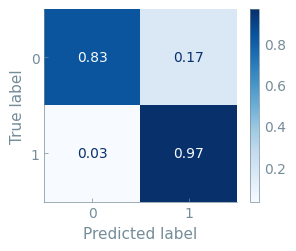

In [65]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_compSensors_confusionMatrix_50_50_size45_XGBoost.pdf', bbox_inches='tight')